# Building a Handbags-Shoes Classifier with Transfer Learning

## Introduction

In this Colab, We will describe a very powerful technique called **Transfer Learning** that can be used to build highly accurate image classification models even when you have very little data. Pretty much any consumer-facing app that uses image AI was probably built using this technique.

We also show how to use a technique called **data augmentation** to effortlessly increase the size of your training dataset, and thereby achieve better accuracy.

---

We will work with ResNet-50 (rather than ResNet-34 as shown in the picture below) since it comes pre-packaged with Keras.

Check out all the pre-trained models available in [Keras](https://keras.io/api/applications/) and in [Tensorflow](https://www.tensorflow.org/hub).

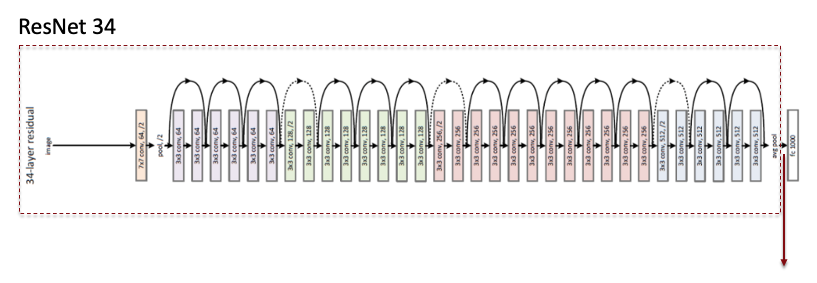

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil, pathlib

# initialize the seeds of different random number generators so that
# the results will be similar every time the notebook is run
keras.utils.set_random_seed(42)

In [8]:
content_dir = pathlib.Path("/content")

for path in content_dir.glob("handbags-shoes.zip*"):
    if path.is_dir():
        shutil.rmtree(path)
        print(f"Removed directory: {path}")
    else:
        path.unlink()
        print(f"Removed file: {path}")

!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip
print(f"Downloaded the zip file: {content_dir/'handbags-shoes.zip'}")

Downloaded the zip file: /content/handbags-shoes.zip


In [9]:
basedir = content_dir/'handbags-shoes'
if basedir.exists():
    shutil.rmtree(basedir)
    print(f"Deleted: {basedir}")

!unzip -qq handbags-shoes.zip
print(f"Unzipped file: {basedir}")

Unzipped file: /content/handbags-shoes


In [10]:
for category in ('handbags', 'shoes'):
    fnames = os.listdir(basedir/category)

    dir = basedir/'train'/category
    os.makedirs(dir)

    # the first 50 examples go into the training set
    for fname in fnames[:50]:
        shutil.copyfile(src=basedir/category/fname, dst=dir/fname)

    dir = basedir/'validation'/category
    os.makedirs(dir)

    # the next 25 examples go into the validation set
    for fname in fnames[50:75]:
        shutil.copyfile(src=basedir/category/fname, dst=dir/fname)

    dir = basedir/'test'/category
    os.makedirs(dir)

    # the remaining examples go into the test set
    for fname in fnames[75:]:
        shutil.copyfile(src=basedir/category/fname, dst=dir/fname)

In [11]:
train_dataset = keras.utils.image_dataset_from_directory(
    basedir/'train',
    image_size=(224,224),
    batch_size=32
)

validation_dataset = keras.utils.image_dataset_from_directory(
    basedir/'validation',
    image_size=(224,224),
    batch_size=32
)

test_dataset = keras.utils.image_dataset_from_directory(
    basedir/'test',
    image_size=(224,224),
    batch_size=32
)

Found 97 files belonging to 2 classes.
Found 48 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [12]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  include_top=False,            # Do n't include the top (final) layer
  input_shape=(224, 224, 3))

In [13]:
resnet50_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

It is a **DEEP** network, all right!!

Next, we run our dataset through "headless ResNet" to get the transformed, "smart" inputs.

In [14]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.resnet50.preprocess_input(images)
    features = resnet50_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [15]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


What's the shape of the tensor that comes out of 'headless' ResNet?

In [16]:
train_features.shape

(97, 7, 7, 2048)

These tensors coming out of "headless" ResNet are smart representations and we can simply attach them to a small NN.  

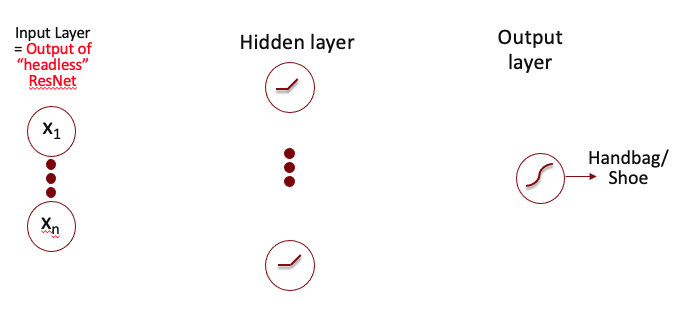

We will use a regularization layer : `Dropout`.

In [17]:
input = keras.Input(shape=(7, 7, 2048))
h = keras.layers.Flatten()(input)
h = keras.layers.Dense(256, activation="relu")(h)
h = keras.layers.Dropout(0.5)(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)
model = keras.Model(input, output)

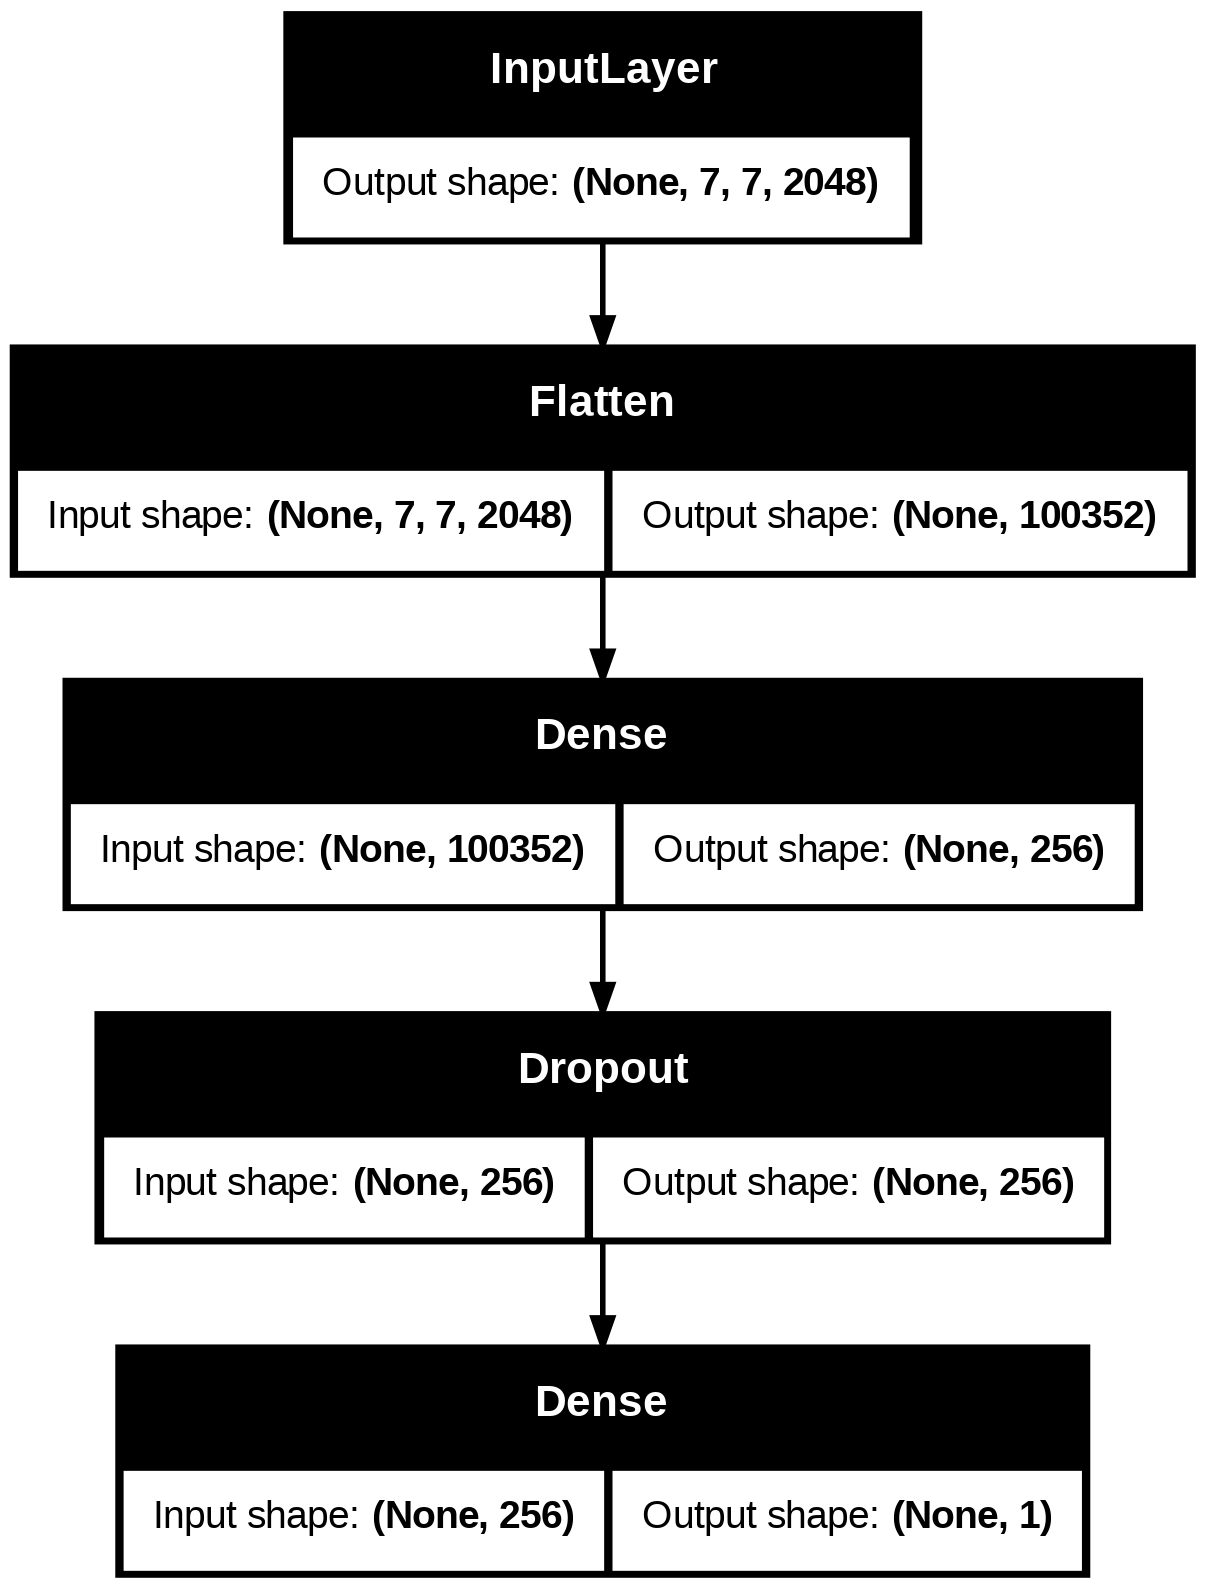

In [18]:
keras.utils.plot_model(model, show_shapes=True)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,690,625 (98.00 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_features,
                    train_labels,
                    epochs=10,
                    validation_data=(val_features, val_labels))

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - accuracy: 0.7352 - loss: 1.3078 - val_accuracy: 0.9792 - val_loss: 0.1652
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 1.0000 - loss: 4.0421e-22 - val_accuracy: 0.9583 - val_loss: 0.4550
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 1.0000 - loss: 6.0730e-12 - val_accuracy: 0.9583 - val_loss: 0.9527
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step - accuracy: 0.9938 - loss: 0.0935 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 0.9792 - val_loss: 2.2570
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.9876 - loss: 0.7506 - val_accuracy: 0.9792 - val_loss: 2.6161
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.9907 - loss: 1.7847 - val_accuracy: 0.9792 - val_loss: 0.2707
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.9907 - loss: 0.1357 - val_accuracy: 1.0000 - v

In [21]:
def plot_loss_curves(history):
  plt.clf()
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def plot_acc_curves(history):
  plt.clf()
  history_dict = history.history
  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

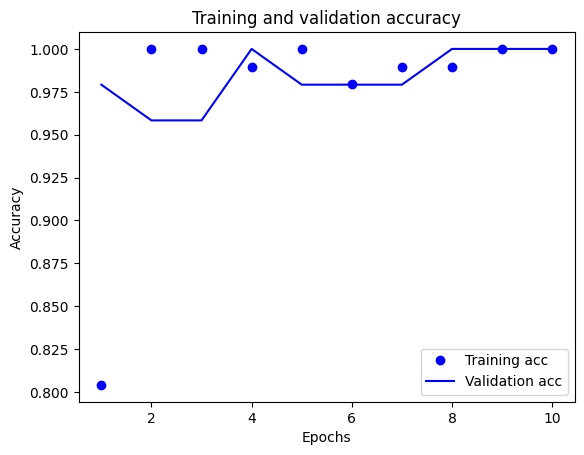

In [22]:
plot_acc_curves(history)

The training and validation accuracies are 100%! This looks promising!

In [23]:
model.evaluate(test_features, test_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0000e+00


[0.0, 1.0]

**IMPRESSIVE ACCURACY ON THE TEST SET!!**


Let's pause for a moment to reflect on what we have done.

We have built an amazingly accurate handbags or shoes classifier with *just* 100 training images!

That's the power of transfer learning!!

OK, let's test it LIVE with my laptop's webcam.

In [24]:
# Camera Capture code snippet courtesy Google Colab


from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [25]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = keras.applications.resnet50.preprocess_input(arr)
  arr = np.expand_dims(arr, axis=0)
  arr = resnet50_base(arr)
  pred = model.predict(arr)
  pred = "SHOE" if pred > 0.5 else "HANDBAG"
  print("************************************\n\n")
  print(f"...........it is a {pred}!")
  print("\n\n************************************\n\n")

In [34]:
'''
# Camera Capture code snippet courtesy Google Colab

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
'''

"\n# Camera Capture code snippet courtesy Google Colab\n\nfrom IPython.display import Image\ntry:\n  filename = take_photo()\n  print('Saved to {}'.format(filename))\n\n  # Show the image which was just taken.\n  display(Image(filename))\n  predict_image(filename)\nexcept Exception as err:\n  # Errors will be thrown if the user does not have a webcam or if they do not\n  # grant the page permission to access it.\n  print(str(err))\n"

**THE END**